In [1]:
import ast
import pandas as pd
import numpy as np
from utils import *

from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import tensorflow.random as random

seed = 111
random.set_seed(seed)
np.random.seed(seed)

In [2]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [2]:
df = pd.read_csv("cleaned_data/cleaned_reviews_4.csv")
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review,text,rating,sentiment,detoken
0,"This started out strong, but it went downhill ...","[start, out, strong, go, downhill, fairly, qui...",1,0,start out strong go downhill fairly quickly no...
1,"A decently written YA book, but I can't even c...","[decently, write, ya, book, can, even, conside...",1,0,decently write ya book can even consider end o...
2,"Ugh...I tried, I honestly tried. I'm a huge fa...","[ugh, try, honestly, try, huge, fan, scott, we...",1,0,ugh try honestly try huge fan scott westerfeld...
3,I hate to give any book this low of a rating -...,"[hate, give, any, book, low, rat, know, take, ...",1,0,hate give any book low rat know take actually ...
4,Main points: \n 1. Never ever introduce a poin...,"[main, point, never, ever, introduce, point, v...",1,0,main point never ever introduce point view sid...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     14000 non-null  object
 1   text       14000 non-null  object
 2   rating     14000 non-null  int64 
 3   sentiment  14000 non-null  int64 
 4   detoken    14000 non-null  object
dtypes: int64(2), object(3)
memory usage: 547.0+ KB


In [3]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 222)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")

There are 1216862 train words in total and the vocabulary size is 29960.


In [4]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

MAX_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

MAX_LENGTH = 150

x_train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

(11200, 150)
(2800, 150)
(11200,)
(2800,)
Found 29998 unique tokens


In [50]:
EMBEDDING_DIM = 300
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False)

del(embedding_matrix)

### CNN

In [109]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          6000000   
                                                                 
 conv1d_22 (Conv1D)          (None, 147, 32)           38432     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 36, 32)           0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 1152)              0         
                                                                 
 dense_64 (Dense)            (None, 16)                18448     
                                                                 
 dense_65 (Dense)            (None, 1)                 17        
                                                     

In [88]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
140/140 [==============================] - 6s 41ms/step - loss: 0.5333 - accuracy: 0.7190 - val_loss: 0.4737 - val_accuracy: 0.7821
Epoch 2/5
140/140 [==============================] - 6s 42ms/step - loss: 0.2962 - accuracy: 0.8818 - val_loss: 0.4848 - val_accuracy: 0.7857
Epoch 3/5
140/140 [==============================] - 6s 41ms/step - loss: 0.1669 - accuracy: 0.9411 - val_loss: 1.1682 - val_accuracy: 0.5643
Epoch 4/5
140/140 [==============================] - 6s 41ms/step - loss: 0.0619 - accuracy: 0.9865 - val_loss: 0.6754 - val_accuracy: 0.7723
Epoch 5/5
140/140 [==============================] - 6s 43ms/step - loss: 0.0186 - accuracy: 0.9992 - val_loss: 0.8169 - val_accuracy: 0.7580


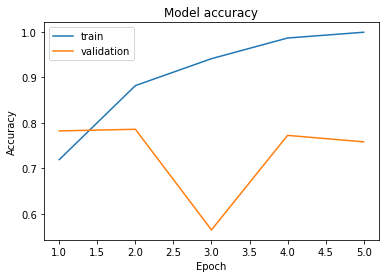

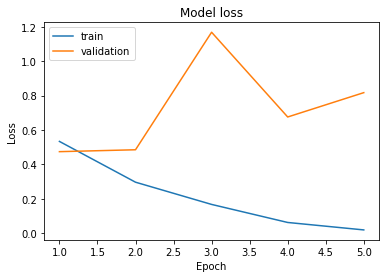

88/88 - 1s - loss: 0.5398 - accuracy: 0.8282 - 745ms/epoch - 8ms/step
Test accuracy: 0.8282142877578735
Confusion matrix: 
 [[1042  358]
 [ 123 1277]]
Test accuracy: 0.8282142857142857


In [89]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### LSTM

In [93]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(50))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          6000000   
                                                                 
 lstm_10 (LSTM)              (None, 50)                70200     
                                                                 
 dense_56 (Dense)            (None, 16)                816       
                                                                 
 dense_57 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,071,033
Trainable params: 71,033
Non-trainable params: 6,000,000
_________________________________________________________________
None


In [94]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
140/140 [==============================] - 12s 75ms/step - loss: 0.6511 - accuracy: 0.6300 - val_loss: 0.9646 - val_accuracy: 0.0063
Epoch 2/5
140/140 [==============================] - 10s 73ms/step - loss: 0.6343 - accuracy: 0.6533 - val_loss: 0.8048 - val_accuracy: 0.0719
Epoch 3/5
140/140 [==============================] - 11s 79ms/step - loss: 0.6024 - accuracy: 0.6738 - val_loss: 0.5510 - val_accuracy: 0.9103
Epoch 4/5
140/140 [==============================] - 11s 76ms/step - loss: 0.5644 - accuracy: 0.7298 - val_loss: 1.3518 - val_accuracy: 0.0196
Epoch 5/5
140/140 [==============================] - 10s 75ms/step - loss: 0.6181 - accuracy: 0.6640 - val_loss: 1.1105 - val_accuracy: 0.1460


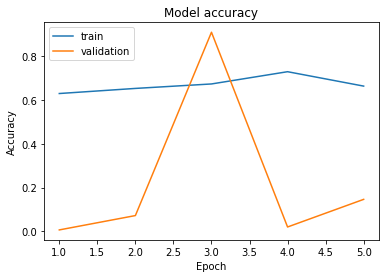

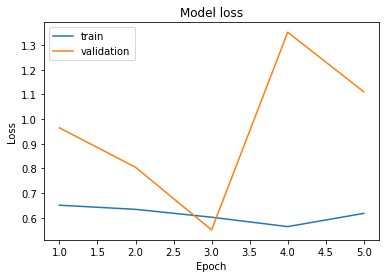

88/88 - 2s - loss: 0.7033 - accuracy: 0.5654 - 2s/epoch - 25ms/step
Test accuracy: 0.5653571486473083
Confusion matrix: 
 [[ 217 1183]
 [  34 1366]]
Test accuracy: 0.5653571428571429


In [95]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### GRU

In [63]:
model = Sequential()
model.add(embedding_layer)
model.add(GRU(32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          6000000   
                                                                 
 gru_4 (GRU)                 (None, 32)                32064     
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dense_37 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,032,609
Trainable params: 32,609
Non-trainable params: 6,000,000
_________________________________________________________________
None


In [64]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
140/140 [==============================] - 10s 60ms/step - loss: 0.6490 - accuracy: 0.6369 - val_loss: 1.0825 - val_accuracy: 0.0683
Epoch 2/5
140/140 [==============================] - 8s 57ms/step - loss: 0.5978 - accuracy: 0.6463 - val_loss: 0.7273 - val_accuracy: 0.1460
Epoch 3/5
140/140 [==============================] - 7s 53ms/step - loss: 0.6305 - accuracy: 0.6445 - val_loss: 0.8761 - val_accuracy: 0.0920
Epoch 4/5
140/140 [==============================] - 8s 56ms/step - loss: 0.6235 - accuracy: 0.6626 - val_loss: 0.9300 - val_accuracy: 0.1558
Epoch 5/5
140/140 [==============================] - 8s 55ms/step - loss: 0.5966 - accuracy: 0.6771 - val_loss: 0.9647 - val_accuracy: 0.1576


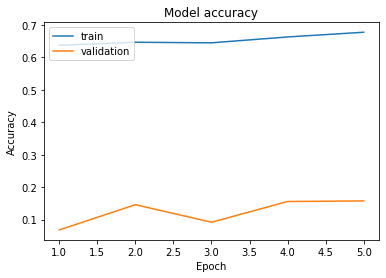

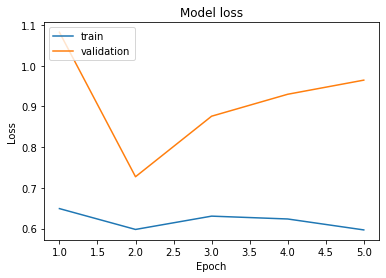

88/88 - 1s - loss: 0.6740 - accuracy: 0.5693 - 1s/epoch - 16ms/step
Test accuracy: 0.5692856907844543
Confusion matrix: 
 [[ 230 1170]
 [  36 1364]]
Test accuracy: 0.5692857142857143


In [65]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### CNN + LSTM

In [102]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation="relu"))
model.add(MaxPooling1D(4))
model.add(LSTM(32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          6000000   
                                                                 
 conv1d_21 (Conv1D)          (None, 147, 32)           38432     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 36, 32)           0         
 g1D)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_62 (Dense)            (None, 16)                528       
                                                                 
 dense_63 (Dense)            (None, 1)                 17        
                                                     

In [103]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
140/140 [==============================] - 6s 34ms/step - loss: 0.5307 - accuracy: 0.7286 - val_loss: 0.6560 - val_accuracy: 0.7357
Epoch 2/5
140/140 [==============================] - 4s 30ms/step - loss: 0.3483 - accuracy: 0.8548 - val_loss: 0.3556 - val_accuracy: 0.8603
Epoch 3/5
140/140 [==============================] - 4s 32ms/step - loss: 0.3028 - accuracy: 0.8760 - val_loss: 0.6870 - val_accuracy: 0.6969
Epoch 4/5
140/140 [==============================] - 4s 30ms/step - loss: 0.2325 - accuracy: 0.9102 - val_loss: 0.3503 - val_accuracy: 0.8509
Epoch 5/5
140/140 [==============================] - 4s 30ms/step - loss: 0.1947 - accuracy: 0.9270 - val_loss: 0.3448 - val_accuracy: 0.8701


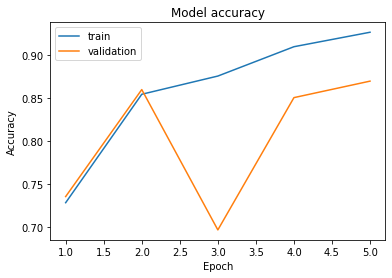

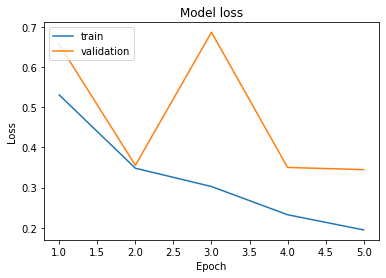

88/88 - 1s - loss: 0.3278 - accuracy: 0.8661 - 791ms/epoch - 9ms/step
Test accuracy: 0.8660714030265808
Confusion matrix: 
 [[1214  186]
 [ 189 1211]]
Test accuracy: 0.8660714285714286


In [104]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### CNN + GRU

In [99]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation="relu"))
model.add(MaxPooling1D(4))
model.add(GRU(32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          6000000   
                                                                 
 conv1d_20 (Conv1D)          (None, 147, 32)           38432     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 36, 32)           0         
 g1D)                                                            
                                                                 
 gru_7 (GRU)                 (None, 32)                6336      
                                                                 
 dense_60 (Dense)            (None, 16)                528       
                                                                 
 dense_61 (Dense)            (None, 1)                 17        
                                                     

In [100]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
140/140 [==============================] - 6s 32ms/step - loss: 0.6434 - accuracy: 0.6412 - val_loss: 0.9608 - val_accuracy: 0.1464
Epoch 2/5
140/140 [==============================] - 4s 29ms/step - loss: 0.4358 - accuracy: 0.7916 - val_loss: 0.4059 - val_accuracy: 0.8397
Epoch 3/5
140/140 [==============================] - 4s 31ms/step - loss: 0.3066 - accuracy: 0.8724 - val_loss: 0.4241 - val_accuracy: 0.8192
Epoch 4/5
140/140 [==============================] - 4s 31ms/step - loss: 0.2293 - accuracy: 0.9118 - val_loss: 0.2749 - val_accuracy: 0.8866
Epoch 5/5
140/140 [==============================] - 4s 31ms/step - loss: 0.1804 - accuracy: 0.9353 - val_loss: 0.4681 - val_accuracy: 0.8219


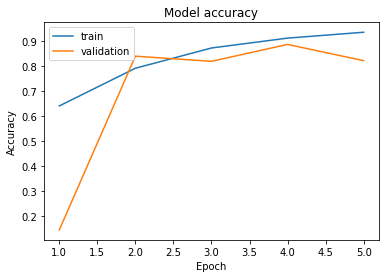

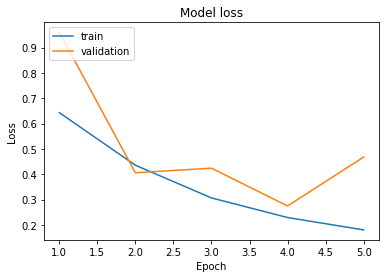

88/88 - 1s - loss: 0.3351 - accuracy: 0.8664 - 911ms/epoch - 10ms/step
Test accuracy: 0.866428554058075
Confusion matrix: 
 [[1155  245]
 [ 129 1271]]
Test accuracy: 0.8664285714285714


In [101]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")